<a href="https://colab.research.google.com/github/ZagainovNikita/Stepik_NN_Learning_Samsung_Research/blob/main/6_CIFAR-10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import torch
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torchvision
import torch.nn.functional as F

# *Data importing*

In [ ]:
CIFAR_train = torchvision.datasets.CIFAR10('/', train=True, download=True)
CIFAR_test = torchvision.datasets.CIFAR10('/', train=False, download=True)
x_train = torch.FloatTensor(CIFAR_train.data)
y_train = torch.LongTensor(CIFAR_train.targets)
x_test = torch.FloatTensor(CIFAR_test.data)
y_test = torch.LongTensor(CIFAR_test.targets)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
x_train /= 255
x_test /= 255

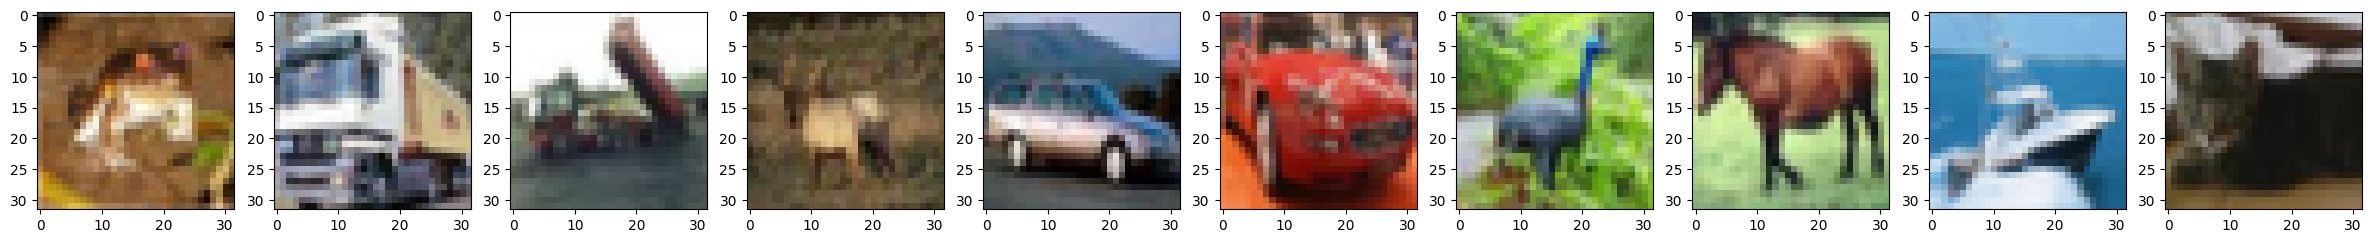

In [ ]:
plt.figure(figsize=(30,5))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(x_train[i])

In [ ]:
x_train = x_train.permute(0,3,1,2)
x_test = x_test.permute(0,3,1,2)

# *Modified LeNet Construcion*

In [ ]:
class LeNet(torch.nn.Module):
    def __init__(self,
                 activation='tanh',
                 pooling='avg',
                 conv_size=5,
                 use_batch_norm=False):
        super().__init__()

        self.conv_size = conv_size
        self.use_batch_norm = use_batch_norm


        activation_function = eval(f'torch.nn.{activation}()')

        if pooling == 'avg':
            pooling_layer = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        elif pooling == 'max':
            pooling_layer  = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        else:
            raise NotImplementedError

        if conv_size == 5:
            self.conv1 = torch.nn.Conv2d(
                in_channels=3, out_channels=6, kernel_size=5, padding=0)
        elif conv_size == 3:
            self.conv1_1 = torch.nn.Conv2d(
                in_channels=3, out_channels=6, kernel_size=3, padding=0)
            self.conv1_2 = torch.nn.Conv2d(
                in_channels=6, out_channels=6, kernel_size=3, padding=0)
        else:
            raise NotImplementedError

        self.act1 = activation_function
        self.bn1 = torch.nn.BatchNorm2d(num_features=6)
        self.pool1 = pooling_layer

        if conv_size == 5:
            self.conv2 = self.conv2 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=5, padding=0)
        elif conv_size == 3:
            self.conv2_1 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=3, padding=0)
            self.conv2_2 = torch.nn.Conv2d(
                in_channels=16, out_channels=16, kernel_size=3, padding=0)
        else:
            raise NotImplementedError

        self.act2 = activation_function
        self.bn2 = torch.nn.BatchNorm2d(num_features=16)
        self.pool2 = pooling_layer

        self.fc1 = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3 = activation_function

        self.fc2 = torch.nn.Linear(120, 84)
        self.act4 = activation_function

        self.fc3 = torch.nn.Linear(84, 10)

    def forward(self, x):
        if self.conv_size == 5:
            x = self.conv1(x)
        elif self.conv_size == 3:
            x = self.conv1_2(self.conv1_1(x))
        x = self.act1(x)
        if self.use_batch_norm:
            x = self.bn1(x)
        x = self.pool1(x)

        if self.conv_size == 5:
            x = self.conv2(x)
        elif self.conv_size == 3:
            x = self.conv2_2(self.conv2_1(x))
        x = self.act2(x)
        if self.use_batch_norm:
            x = self.bn2(x)
        x = self.pool2(x)

        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)

        return x

# *Train function*

In [ ]:
def train(net, x_train, y_train, x_test, y_test, n_epochs=30, do_print=True):
    device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)

    batch_size = 100

    loss_val_history = []
    accuracy_history = []

    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3)

    for epoch in range(n_epochs):
        net.train()

        order = np.random.permutation(x_train.shape[0])

        for start_index in range(0, x_train.shape[0], batch_size):
            inds = order[start_index : start_index + batch_size]
            x_train_batch = x_train[inds].to(device)
            y_train_batch = y_train[inds].to(device)

            optimizer.zero_grad()

            y_pred_batch = net.forward(x_train_batch)
            loss_val = loss_function(y_pred_batch, y_train_batch)
            loss_val.backward()

            optimizer.step()

        net.eval()

        order = np.random.permutation(x_test.shape[0])

        temp_loss_storage = []
        temp_accuracy_storage = []

        for start_index in range(0, x_test.shape[0], batch_size):
            inds = order[start_index : start_index + batch_size]
            x_test_batch = x_test[inds].to(device)
            y_test_batch = y_test[inds].to(device)

            y_pred_batch = net.forward(x_test_batch)

            loss_val = loss_function(y_pred_batch, y_test_batch).data.cpu()
            accuracy = (y_pred_batch.argmax(dim=1) == y_test_batch).float().mean().data.cpu()

            temp_loss_storage.append(loss_val)
            temp_accuracy_storage.append(accuracy)

        overall_loss = sum(temp_loss_storage)
        overall_accuracy = sum(temp_accuracy_storage)/len(temp_accuracy_storage)

        if do_print:
            print(f'epoch: {epoch}; loss: {overall_loss}; accuracy: {overall_accuracy}')

        loss_val_history.append(overall_loss)
        accuracy_history.append(overall_accuracy)

    return net, loss_val_history, accuracy_history

# *LeNet testing*

In [ ]:
net = LeNet(activation='ReLU', conv_size=3, pooling='max', use_batch_norm=True)
learned_net, loss_history, accuracy_history = train(net, x_train, y_train, x_test, y_test, n_epochs = 50, do_print = True)

KeyboardInterrupt: ignored

In [ ]:
plt.plot(accuracy_history, label='acc')
plt.legend()

# *Construction of a Net to solve CIFAR10*

In [ ]:
class CIFARNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.batch_norm0 = torch.nn.BatchNorm2d(3)

        self.conv1 = torch.nn.Conv2d(3, 16, 3, padding=1)
        self.act1  = torch.nn.ReLU()
        self.batch_norm1 = torch.nn.BatchNorm2d(16)
        self.pool1 = torch.nn.MaxPool2d(2, 2)

        self.conv2 = torch.nn.Conv2d(16, 32, 3, padding=1)
        self.act2  = torch.nn.ReLU()
        self.batch_norm2 = torch.nn.BatchNorm2d(32)
        self.pool2 = torch.nn.MaxPool2d(2, 2)

        self.conv3 = torch.nn.Conv2d(32, 64, 3, padding=1)
        self.act3  = torch.nn.ReLU()
        self.batch_norm3 = torch.nn.BatchNorm2d(64)

        self.fc1   = torch.nn.Linear(8 * 8 * 64, 256)
        self.act4  = torch.nn.Tanh()
        self.batch_norm4 = torch.nn.BatchNorm1d(256)

        self.fc2   = torch.nn.Linear(256, 64)
        self.act5  = torch.nn.Tanh()
        self.batch_norm5 = torch.nn.BatchNorm1d(64)

        self.fc3   = torch.nn.Linear(64, 10)

    def forward(self, x):
        x = self.batch_norm0(x)
        x = self.conv1(x)
        x = self.act1(x)
        x = self.batch_norm1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.batch_norm2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.act3(x)
        x = self.batch_norm3(x)

        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act4(x)
        x = self.batch_norm4(x)
        x = self.fc2(x)
        x = self.act5(x)
        x = self.batch_norm5(x)
        x = self.fc3(x)

        return x

# *CIFARNet testing*

In [ ]:
learned_cifar, loss_history, accuracy_history = train(CIFARNet(), x_train, y_train, x_test, y_test, n_epochs=50, do_print=True)

epoch: 0; loss: 11.624649047851562; accuracy: 0.5934000015258789
epoch: 1; loss: 9.56698226928711; accuracy: 0.6643000841140747
epoch: 2; loss: 9.276748657226562; accuracy: 0.6794000267982483
epoch: 3; loss: 9.732412338256836; accuracy: 0.6815999746322632
epoch: 4; loss: 10.48968505859375; accuracy: 0.6841000914573669
epoch: 5; loss: 11.159303665161133; accuracy: 0.6913000345230103
epoch: 6; loss: 11.9348726272583; accuracy: 0.688200056552887
epoch: 7; loss: 12.410189628601074; accuracy: 0.6902000904083252
epoch: 8; loss: 12.661731719970703; accuracy: 0.6996999979019165
epoch: 9; loss: 12.809093475341797; accuracy: 0.6991000175476074
epoch: 10; loss: 13.006980895996094; accuracy: 0.6987000107765198
epoch: 11; loss: 13.172560691833496; accuracy: 0.6998000144958496
epoch: 12; loss: 13.35605525970459; accuracy: 0.7001000642776489
epoch: 13; loss: 13.536107063293457; accuracy: 0.7005000710487366
epoch: 14; loss: 13.638762474060059; accuracy: 0.6989001035690308
epoch: 15; loss: 13.763312339

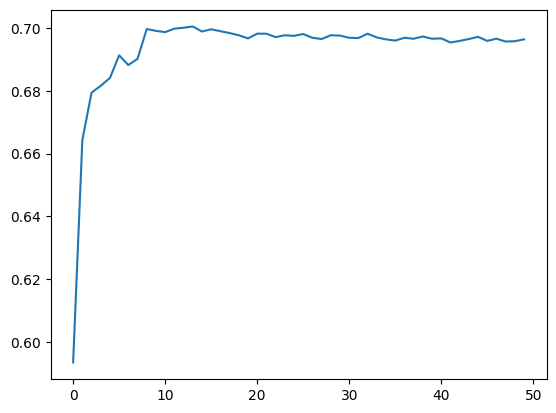

In [ ]:
plt.plot(accuracy_history)

# *ResNet Comparsion*

In [ ]:
resnet18 = torchvision.models.resnet18

In [ ]:
learned_resnet, loss_history, accuracy_history = train(resnet18(), x_train, y_train, x_test, y_test, n_epochs = 30, do_print=True)

epoch: 0; loss: 18.164325714111328; accuracy: 0.39259999990463257
epoch: 1; loss: 11.983009338378906; accuracy: 0.5780000686645508
epoch: 2; loss: 14.111503601074219; accuracy: 0.5389000177383423
epoch: 3; loss: 14.205265045166016; accuracy: 0.5589000582695007
epoch: 4; loss: 11.506628036499023; accuracy: 0.6341999769210815
epoch: 5; loss: 12.850561141967773; accuracy: 0.6209999918937683
epoch: 6; loss: 12.461763381958008; accuracy: 0.6508000493049622
epoch: 7; loss: 17.14929962158203; accuracy: 0.6125999689102173
epoch: 8; loss: 16.629179000854492; accuracy: 0.6224000453948975
epoch: 9; loss: 17.348039627075195; accuracy: 0.6007999777793884
epoch: 10; loss: 16.716529846191406; accuracy: 0.6420000195503235
epoch: 11; loss: 15.954610824584961; accuracy: 0.6572999954223633
epoch: 12; loss: 15.472366333007812; accuracy: 0.6776000261306763
epoch: 13; loss: 16.284339904785156; accuracy: 0.6723999977111816
epoch: 14; loss: 17.53439712524414; accuracy: 0.6614000201225281
epoch: 15; loss: 16.7

# *ResNet class construction*

In [ ]:
class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1, option='A'):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

        #self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [ ]:
resnet = ResNet(BasicBlock, [10,10,10])

In [ ]:
result_net, loss_history, accuracy_history = train(resnet, x_train, y_train, x_test, y_test, n_epochs=30, do_print=True)

epoch: 0; loss: 104.85034942626953; accuracy: 0.626300036907196
epoch: 1; loss: 78.88585662841797; accuracy: 0.728600025177002
epoch: 2; loss: 72.8806381225586; accuracy: 0.7490000128746033
epoch: 3; loss: 75.71595764160156; accuracy: 0.7508997917175293
epoch: 4; loss: 60.69411849975586; accuracy: 0.794999897480011
epoch: 5; loss: 63.10662078857422; accuracy: 0.7869998216629028
epoch: 6; loss: 66.78518676757812; accuracy: 0.7813001871109009
epoch: 7; loss: 63.03007125854492; accuracy: 0.8030000925064087
epoch: 8; loss: 58.27665328979492; accuracy: 0.8097999691963196
epoch: 9; loss: 71.52391052246094; accuracy: 0.7975001335144043
epoch: 10; loss: 67.66690826416016; accuracy: 0.8077999949455261
epoch: 11; loss: 63.609092712402344; accuracy: 0.8240999579429626
epoch: 12; loss: 66.6332015991211; accuracy: 0.8226999640464783
epoch: 13; loss: 68.98589324951172; accuracy: 0.815500020980835
epoch: 14; loss: 72.6642074584961; accuracy: 0.8195000290870667
epoch: 15; loss: 88.13623809814453; accu

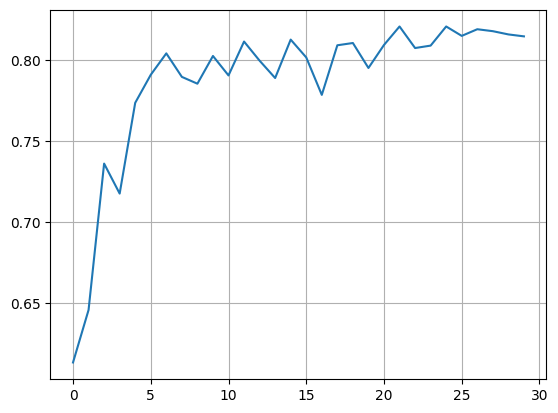

In [ ]:
plt.plot(accuracy_history)
plt.grid()